<a href="https://colab.research.google.com/github/Jayasri02Sridharan/Reinsurance-Pricing-Claim-Simulation/blob/main/3_Frequency_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### 1. Load cleaned dataset

In [ ]:
df = pd.read_csv("/content/allstate_cleaned_claims.csv")
df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont10,cont11,cont12,cont13,cont14,loss,accident_year,cpi_index,inflation_factor,loss_infl_adj
0,1,A,B,A,B,A,A,A,A,B,...,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18,2020,105,1.238095,2740.127619
1,2,A,B,A,A,A,A,A,A,B,...,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60,2023,130,1.000000,1283.600000
2,5,A,B,A,A,B,A,A,A,B,...,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09,2022,120,1.083333,3255.514167
3,10,B,B,A,B,A,A,A,A,B,...,0.44467,0.327915,0.321570,0.605077,0.602642,939.85,2021,112,1.160714,1090.897321
4,11,A,B,A,B,A,A,A,A,B,...,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85,2019,100,1.300000,3593.005000


In [ ]:
# Create synthetic accident year
np.random.seed(42)

df["accident_year"] = np.random.choice(
    np.arange(2015, 2025),
    size=len(df),
    replace=True
)
df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont10,cont11,cont12,cont13,cont14,loss,accident_year,cpi_index,inflation_factor,loss_infl_adj
0,1,A,B,A,B,A,A,A,A,B,...,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18,2021,105,1.238095,2740.127619
1,2,A,B,A,A,A,A,A,A,B,...,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60,2018,130,1.000000,1283.600000
2,5,A,B,A,A,B,A,A,A,B,...,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09,2022,120,1.083333,3255.514167
3,10,B,B,A,B,A,A,A,A,B,...,0.44467,0.327915,0.321570,0.605077,0.602642,939.85,2019,112,1.160714,1090.897321
4,11,A,B,A,B,A,A,A,A,B,...,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85,2021,100,1.300000,3593.005000


In [ ]:
# compute claim counts per year
freq_data = df.groupby("accident_year").size().reset_index(name="claim_count")
freq_data

,accident_year,claim_count
0,2015,18904
1,2016,18852
2,2017,18686
3,2018,18765
4,2019,18903
5,2020,18838
6,2021,18960
7,2022,18661
8,2023,18712
9,2024,19037


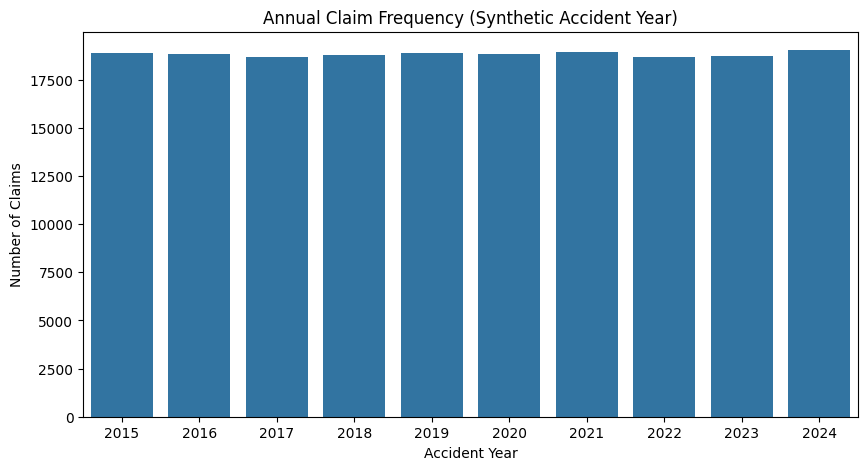

In [ ]:
# plot annual claim counts
plt.figure(figsize=(10,5))
sns.barplot(data=freq_data, x="accident_year", y="claim_count")
plt.title("Annual Claim Frequency (Synthetic Accident Year)")
plt.xlabel("Accident Year")
plt.ylabel("Number of Claims")
plt.show()

In [ ]:
# basic statistics
mean_N = freq_data["claim_count"].mean()
var_N = freq_data["claim_count"].var()

print("Mean annual claims =", mean_N)
print("Variance of annual claims =", var_N)
print("Variance / Mean ratio =", var_N / mean_N)

Mean annual claims = 18831.8
Variance of annual claims = 15390.622222222222
Variance / Mean ratio = 0.817267718551717


* If Var/Mean ≈ 1 → Poisson good

* If Var/Mean > 1 → Negative Binomial better

### 2. Fit Poisson distribution (MLE)

In [ ]:
lambda_hat = mean_N
print("Poisson lambda estimate =", lambda_hat)

Poisson lambda estimate = 18831.8


### 3. Fit Negative Binomial (Method of Moments)

In [ ]:
mu = mean_N

if var_N > mu:
    r_hat = mu**2 / (var_N - mu)
    print("NegBin r estimate =", r_hat)
else:
    r_hat = None
    print("Variance <= mean, NegBin not needed")


Variance <= mean, NegBin not needed


In [ ]:
# Estimating probability parameter
if r_hat is not None:
    p_hat = r_hat / (r_hat + mu)
    print("NegBin p estimate =", p_hat)

### 4. Compare model fit using log-likelihood

In [ ]:
# Poisson log-likelihood
N = freq_data["claim_count"].values

poisson_ll = np.sum(stats.poisson.logpmf(N, mu=lambda_hat))
print("Poisson Log-Likelihood =", poisson_ll)

# Negative binomial log-likelihood
if r_hat is not None:
    nbinom_ll = np.sum(stats.nbinom.logpmf(N, n=r_hat, p=p_hat))
    print("NegBin Log-Likelihood =", nbinom_ll)

Poisson Log-Likelihood = -62.08293795139616


### 5. Compare AIC (Actuarial model selection)

In [ ]:
# poisson: k=1   NegBin: k=2
poisson_aic = 2*1 - 2*poisson_ll
print("Poisson AIC =", poisson_aic)

if r_hat is not None:
    nbinom_aic = 2*2 - 2*nbinom_ll
    print("NegBin AIC =", nbinom_aic)

Poisson AIC = 126.16587590279232


#### Note: Lower AIC = better fit

### 6. Plot observed vs fitted probabilities

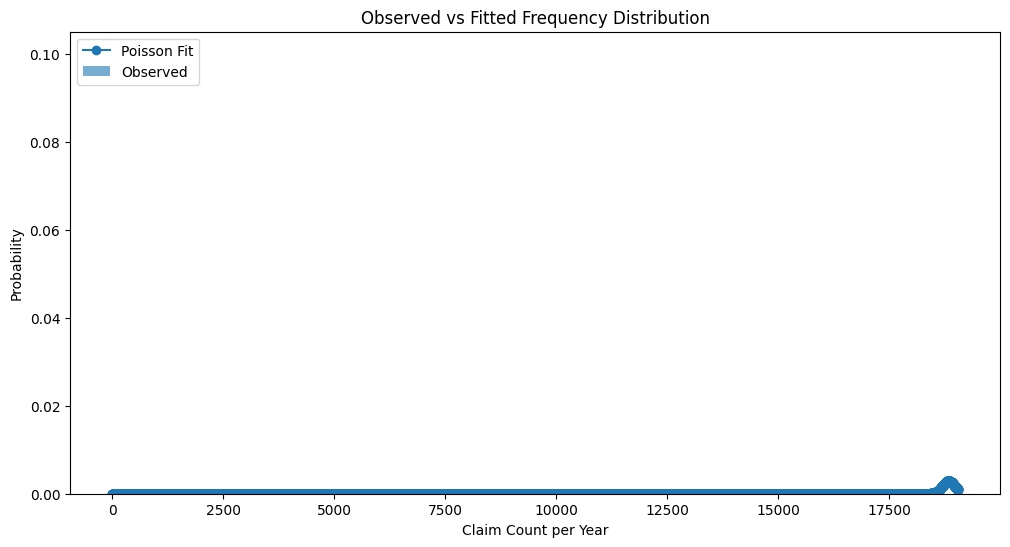

In [ ]:
max_count = N.max()
k_values = np.arange(0, max_count+1)

# Observed frequency distribution
observed_probs = pd.Series(N).value_counts(normalize=True).sort_index()

# Poisson fitted probs
poisson_probs = stats.poisson.pmf(k_values, mu=lambda_hat)

# NegBin fitted probs
if r_hat is not None:
    nbinom_probs = stats.nbinom.pmf(k_values, n=r_hat, p=p_hat)

plt.figure(figsize=(12,6))
plt.bar(observed_probs.index, observed_probs.values, alpha=0.6, label="Observed")

plt.plot(k_values, poisson_probs, marker="o", label="Poisson Fit")

if r_hat is not None:
    plt.plot(k_values, nbinom_probs, marker="s", label="NegBin Fit")

plt.title("Observed vs Fitted Frequency Distribution")
plt.xlabel("Claim Count per Year")
plt.ylabel("Probability")
plt.legend()
plt.show()

### 7. Final conclusion

In [ ]:
if r_hat is None:
    print("Conclusion: Poisson is sufficient since variance is not greater than mean.")
else:
    if nbinom_aic < poisson_aic:
        print("Conclusion: Negative Binomial is preferred (better AIC + captures overdispersion).")
    else:
        print("Conclusion: Poisson is preferred (simpler model + comparable fit).")

Conclusion: Poisson is sufficient since variance is not greater than mean.
